In [2]:
import os,json
import pandas as pd
from datetime import datetime
from dateutil.parser import parse
import numpy as np
import jieba
import jieba.analyse
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', color_codes=True)


In [3]:
### load files from all folders
def list_dirs(dir):                                                                                                  
    r = []                                                                                                            
    subdirs = [x[0] for x in os.walk(dir)]                                                                            
    for subdir in subdirs:                                                                                            
        files = os.walk(subdir).next()[2]                                                                             
        if (len(files) > 1):                                                                                          
            for file in files:                                                                                        
                r.append(subdir + '/'+ file)                                                                         
    return r 
path_comments = list_dirs('weibo/comments/')
path_reposts = list_dirs('weibo/reposts/')
path_statuses = list_dirs('weibo/statuses/')
comment_files = [pos_json for pos_json in path_comments if pos_json.endswith('.json')]
reposts_files = [pos_json for pos_json in path_reposts if pos_json.endswith('.json')]
statuses_files = [pos_json for pos_json in path_statuses if pos_json.endswith('.json')]



def make_df(from_files):
    df = pd.DataFrame(columns = ['id','gender', 'time','location', 'text'])
    for index, json_file in enumerate(from_files):
        json_data = open(json_file)
        text = json.load(json_data)
        user_id = text['user']['id']
        user_gender = text['user']['gender']
        time = parse(text['created_at'])
        if text['user']['location'][0:2] == u'\u6d77\u5916':
            user_loc = text['user']['location'][3:]
        else:    
            user_loc = text['user']['location'][0:2]
        try:
            user_text = text['retweeted_status']['text']
        except:    
            user_text = text['text']
        df.loc[index] = [user_id, user_gender, time, user_loc, user_text]
    return df

print len(comment_files),len(reposts_files),len(statuses_files)


8903 5253 9947


In [4]:
### create dataframes and combine for analysis

df_comments = make_df(comment_files)
df_reposts = make_df(reposts_files)
df_statuses = make_df(statuses_files)

df_comments['type'],df_reposts['type'],df_statuses['type'] = 'comment','repost','statuse'

df = df_comments.append([df_reposts,df_statuses])

In [5]:
df_mk,df_ks = df[df.text.str.lower().str.contains('michael kors|mk')],df[df.text.str.lower().str.contains('kate spade|ks')]



In [9]:
### total number of posts and unique users mentioning Michael Kors
print 'There are', len(df_mk) , 'posts and' , len(df_mk['id'].unique()) , 'users mentioning Michael Kors'

There are 7524 posts and 4270 users mentioning Michael Kors


In [10]:
### total number of posts and unique users mentioning Kate Spade
print 'There are', len(df_ks) , 'posts and' , len(df_ks['id'].unique()) , 'users mentioning Kate Spade'

There are 8114 posts and 4274 users mentioning Kate Spade


In [17]:
### top 10 users with Michael Kors mentions
df_mk.groupby('id').size().nlargest(10)

id
5671523257    145
5689266274    144
3737544502    123
3956831443    107
2417793200     70
2179810147     50
2204576563     46
3764313851     41
3219312864     40
5389076341     40
dtype: int64

In [26]:
### top 10 locations with Michael Kors mentions
df_mk[df_mk.location!=''].groupby('location').size().nlargest(10)

location
美国    1337
其他     823
广东     682
北京     533
上海     483
香港     427
江苏     342
四川     291
浙江     266
湖北     133
dtype: int64

In [344]:
### top 10 users with Kate Spade mentions
df_ks.groupby('id').size().nlargest(10)

id
2187298830    180
3481576475     56
3956831443     54
2879168864     37
2263431535     36
1649283513     34
2964030550     34
3284734883     34
2153953131     31
3127915453     29
dtype: int64

In [24]:
### top 10 locations with Kate Spade mentions
df_ks[df_ks.location!=''].groupby('location').size().nlargest(10)

location
美国    2076
其他     813
广东     757
上海     610
北京     534
浙江     443
江苏     326
四川     229
湖北     181
山东     171
dtype: int64

In [27]:
### create time series data frames
df_mk.index, df_ks.index = df_mk['time'], df_ks['time']
df_mk['date'], df_mk['hour'], df_mk['brand'] = df_mk.index.date, df_mk.index.hour, 'Michael Kors'
df_ks['date'], df_ks['hour'], df_ks['brand'] = df_ks.index.date, df_ks.index.hour, 'Kate Spade'

/Users/danti/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/danti/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [390]:
### top mention date for each brand
print df_mk.groupby('date').size().nlargest(1), df_ks.groupby('date').size().nlargest(1)

date
2015-10-16    422
dtype: int64 date
2015-09-04    519
dtype: int64


In [435]:
### top mention hour for each brand
print df_mk.groupby('hour').size().nlargest(1), df_ks.groupby('hour').size().nlargest(1)

hour
5    606
dtype: int64 hour
2    637
dtype: int64


In [573]:
### popular words associated with Michael Kors
words_mk = u''
for word in df_mk['text'].str.lower():
    words_mk = words_mk + word
    
top_word_mk = jieba.analyse.extract_tags(words_mk, topK=20, withWeight=False, allowPOS=())
pd.DataFrame(top_word_mk).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,kors,michael,mk,cn,http,慈善,饥饿,michaelkors,代购,直邮,刘雯,watchhungerstop,2015,遭受,正品,世界,50,##,粮食,餐食


In [572]:
### popular words associated with Kate Spade
words_ks = u''
for word in df_ks['text'].str.lower():
    words_ks = words_ks + word
    
top_word_ks = jieba.analyse.extract_tags(words_ks, topK=20, withWeight=False, allowPOS=())
pd.DataFrame(top_word_ks).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,spade,kate,cn,http,new,直邮,york,到手,包包,折扣,代购,钱包,2015,holiday,视频,特价,转发,美国,kloss,karlie


In [47]:
df_mk.head()

,id,gender,time,location,text,type,date,hour,brand
time,,,,,,,,,
2015-08-29 00:30:51,2302077230,f,2015-08-29 00:30:51,浙江,MK等他打到RMB2000以下买就值了[偷笑],comment,2015-08-29,0,Michael Kors
2015-08-29 00:38:00,2302077230,f,2015-08-29 00:38:00,浙江,回复@Arielle_K: MK就是“啊我好喜欢这个款式可惜买不起去看看MK有没有同款”，不...,comment,2015-08-29,0,Michael Kors
2015-08-29 04:34:09,1728202521,f,2015-08-29 04:34:09,陕西,@王点点尼莫 现终于开MK了.....[震惊],comment,2015-08-29,4,Michael Kors
2015-08-29 09:08:09,1738272857,f,2015-08-29 09:08:09,广东,香港MK在哪哦？谢谢。,comment,2015-08-29,9,Michael Kors
2015-08-30 12:50:46,3481576475,f,2015-08-30 12:50:46,上海,定了个这个，mk flap 正红色小钱包，可以放100RMB的哦～,comment,2015-08-30,12,Michael Kors


In [57]:
df_mk_type,df_ks_type = df_mk[df_mk['type']!= 'statuse'], df_ks[df_ks['type']!= 'statuse']

df_ts_alltype, df_ts = df_mk.append(df_ks), df_mk_type.append(df_ks_type)


In [35]:
### Michael Kors related comments and reposts count per day 
ts_count_mk = df_mk_type.groupby(['date','type'])['text'].count()
ts_count_mk.head(10)

date        type   
2015-08-29  comment      4
            repost      13
2015-08-30  comment      1
            repost       6
2015-08-31  repost      40
2015-09-01  repost     106
2015-09-02  comment      2
            repost     185
2015-09-03  comment      2
            repost      15
Name: text, dtype: int64

In [36]:
### Kate Spade related comments and reposts count per day 
ts_count_ks = df_ks_type.groupby(['date','type'])['text'].count()
ts_count_ks.head(10)

date        type   
2015-08-31  comment      1
            repost       9
2015-09-01  repost      44
2015-09-02  repost      39
2015-09-03  comment      1
            repost      58
2015-09-04  comment      4
            repost      83
2015-09-05  comment     10
            repost     198
Name: text, dtype: int64

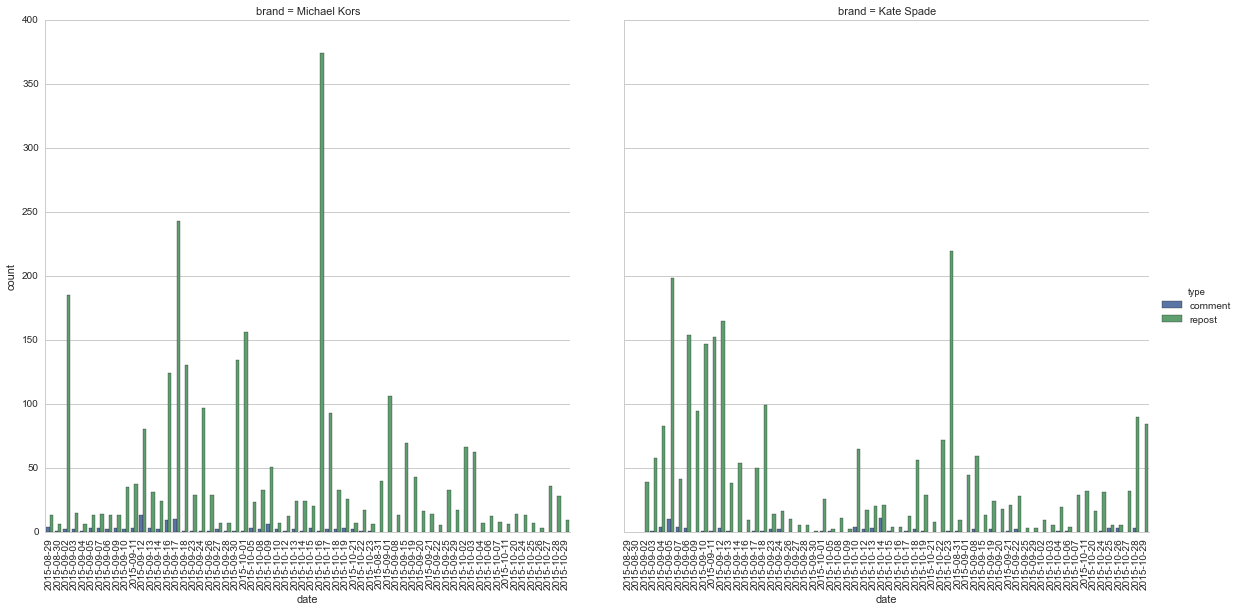

In [56]:
### plot total converstation for each brand over the entire time frame
g = sns.factorplot(x = 'date', hue = 'type', col = 'brand', data =df_ts, size = 8, kind = 'count')
g.set_xticklabels(df_ts.date.unique(),rotation = 90)

In [638]:
### explore user bias -- gender
df.groupby('gender')['id'].nunique()

gender
f    11281
m     1821
Name: id, dtype: int64

In [617]:
daily_post_count = df_ts['text'].groupby([df_ts.date,df_ts.gender]).size().unstack()
daily_posts.head()

gender,f,m
date,,
2015-08-29,16,1
2015-08-30,6,1
2015-08-31,28,22
2015-09-01,84,66
2015-09-02,164,62


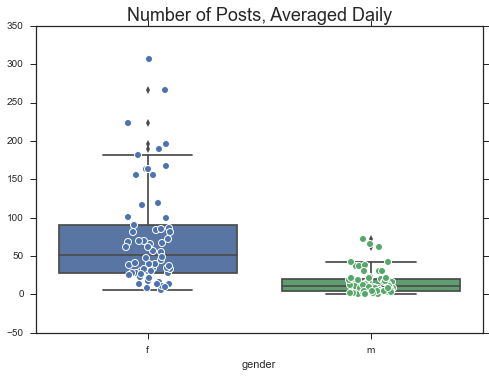

In [621]:
plt.title('Number of Posts, Averaged Daily', fontsize = 18)
sns.boxplot(data = daily_posts)
sns.stripplot(data = daily_posts,jitter=True)

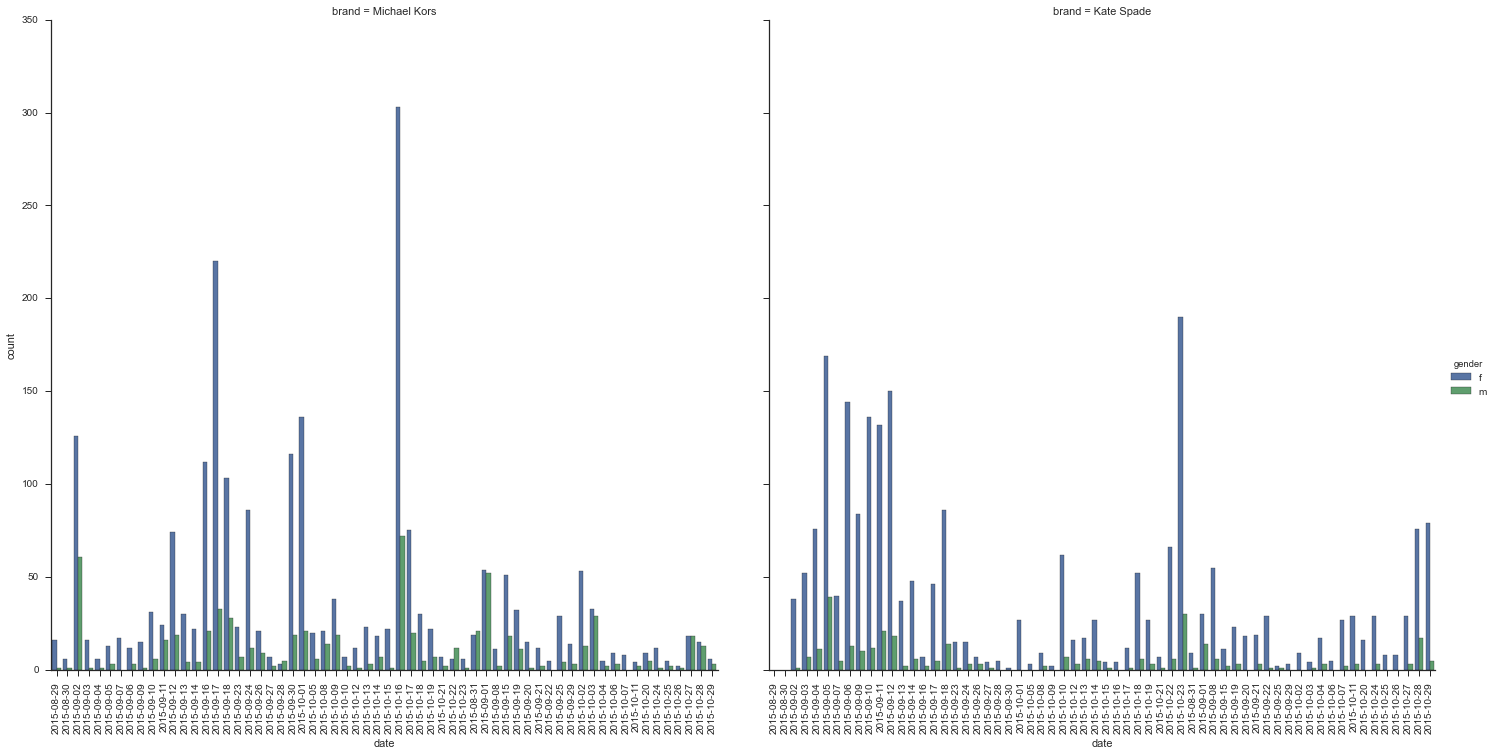

In [622]:
sns.set(style='ticks')
g = sns.factorplot(x = 'date', hue = 'gender', col = 'brand', data =df_ts, size = 10, kind = 'count')
g.set_xticklabels(df_ts.date.unique(),rotation = 90)

In [42]:
### Michael Kors related comments and reposts count per day 
gender_count = df_ts_alltype.groupby(['brand','type','gender'])['text'].count()
gender_count

brand         type     gender
Kate Spade    comment  f           72
                       m           10
              repost   f         2280
                       m          303
              statuse  f         4882
                       m          567
Michael Kors  comment  f           86
                       m           18
              repost   f         2180
                       m          638
              statuse  f         3966
                       m          636
Name: text, dtype: int64

In [68]:
### Not all users care about both brands -- a fair comparison should be based on users who posted about both brands

user = df_ts_alltype.groupby(['id','type','brand'])['text'].count()
user.head(10)

id          type     brand       
345872      repost   Kate Spade      1
64679199    statuse  Kate Spade      1
                     Michael Kors    3
1001617114  repost   Michael Kors    1
1002485875  statuse  Kate Spade      1
1002489981  repost   Michael Kors    2
1004465701  repost   Michael Kors    1
1004660240  repost   Michael Kors    1
1004769935  repost   Kate Spade      1
1005018524  statuse  Kate Spade      1
Name: text, dtype: int64

In [84]:
### use the ratio of each users unqiue post on Michael Kors over the number of unqiue post on Kate Spade 
selected_users = pd.merge(df_mk, df_ks, how = 'inner', on = 'id')
(selected_users.groupby('id')['time_x'].nunique()/selected_users.groupby('id')['time_y'].nunique()).nlargest(20)

id
2417793200    70.000000
3764313851    41.000000
5389076341    40.000000
5050308734    31.000000
5631226835    22.000000
2674368443    20.000000
1774848751    17.000000
5151249029    13.000000
5270124462    13.000000
2254793841    11.000000
3273290050    11.000000
5676410088    10.500000
1351268893     9.000000
2556276230     9.000000
3167578530     8.000000
1777442367     7.500000
3737544502     7.235294
1583605767     7.000000
1869801547     7.000000
1993768157     7.000000
dtype: float64

In [20]:
len(selected_users) 
#len(df[df['user_id_hash'].isin(selected_users)]['user_id_hash'].unique())

602

## low average engagement time and low engagement number on weekends -- cheaper ad price on weekends?

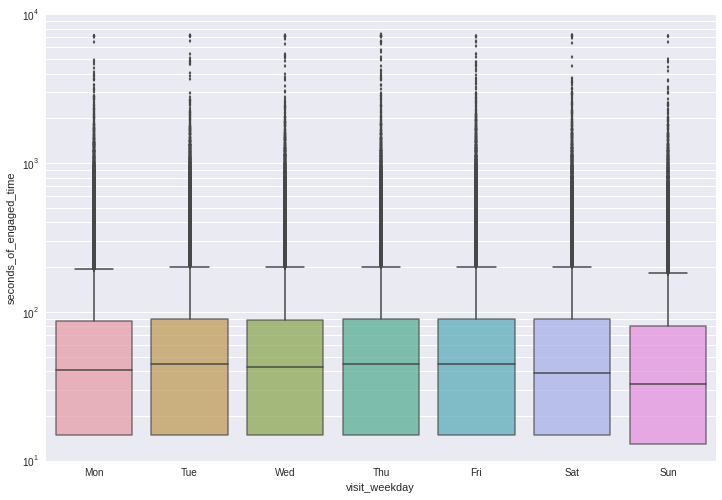

In [9]:

plt.figure(figsize = (12,8))
plt.yscale('log')
weekday_engagement = sns.boxplot(ts.seconds_of_engaged_time, groupby = ts.visit_weekday, alpha=0.7).set_xticklabels(week_label)


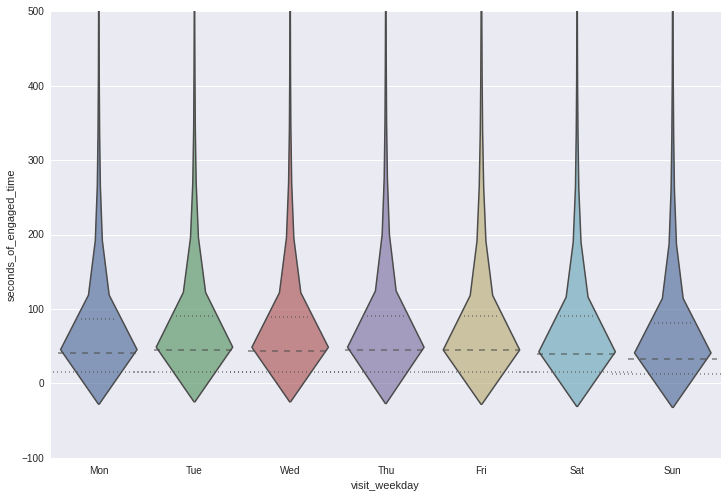

In [91]:
week_label = 'Mon','Tue','Wed','Thu','Fri','Sat','Sun'
plt.figure(figsize = (12,8))
plt.ylim(-100,500)
weekday_engagement_vio = sns.violinplot(ts.seconds_of_engaged_time, groupby = ts.visit_weekday, alpha=0.7).set_xticklabels(week_label)


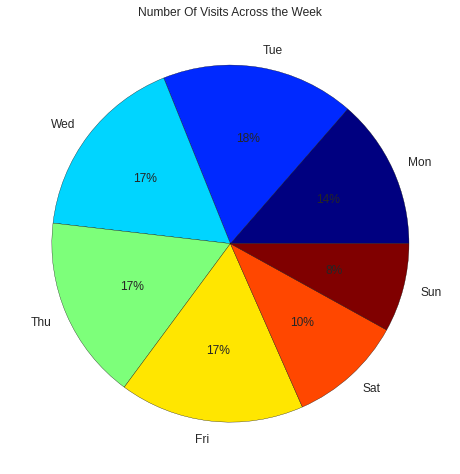

In [10]:
ts_weekday = ts.groupby('visit_weekday',as_index = True)

ts_weekday.size().plot(kind = 'pie',figsize = (8,8), labels = week_label,title = 'Number Of Visits Across the Week',autopct = '%1.0f%%', colormap = 'jet', fontsize = 12)


## lower average engagement time during lunch hours! -- hungry people cannot focus?

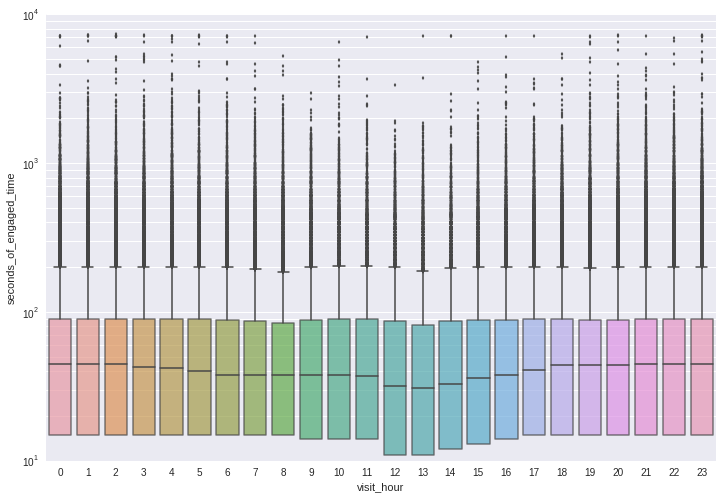

In [11]:
plt.figure(figsize = (12,8))
plt.yscale('log')
hour_engagement = sns.boxplot(ts.seconds_of_engaged_time, groupby = ts.visit_hour, alpha=0.7)

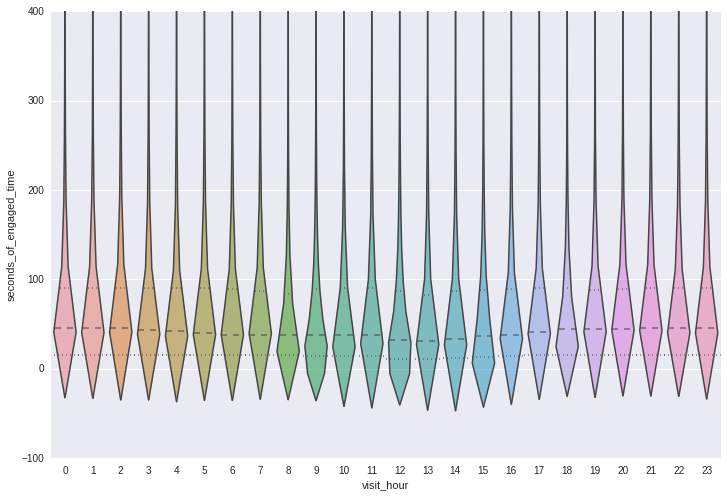

In [93]:
plt.figure(figsize = (12,8))
plt.ylim(-100,400)
hour_engagement_vio = sns.violinplot(ts.seconds_of_engaged_time, groupby = ts.visit_hour, alpha=0.7)

# Engagement boosting title words? 
## from titles with the top 1000 average engagement time

In [12]:
engaging_link = [x for x in df.groupby('relative_path')['seconds_of_engaged_time'].mean().order(ascending=False)[0:1000].index]

engaging_title = [re.sub('-', ' ', re.split('/',x)[-1]) for x in engaging_link]

engaging_title[0:5]  # top 5 titles with the highest average engaged_time

['putting your baby in a cage used to be perfectly acceptable',
 'jon stewart jezebel thinks im a sexist prick',
 'formerly rich lady is our new favorite blogger',
 'paul narang is americas most eligible man',
 'chaz bono explains what transgender means to david letterman']

In [13]:
def popular_words(word_list):
    
    cv_uni = CountVectorizer(ngram_range = (1,2), stop_words = nltk.corpus.stopwords.words('english'), max_features=50)
    counts_uni = cv_uni.fit_transform(word_list).toarray().ravel()                                     
    words_pop = np.array(cv_uni.get_feature_names()) 

    return words_pop

In [14]:
engaging_words = [ word_tokenize(x) for x in engaging_title]
wordlist = list(itertools.chain.from_iterable(engaging_words))

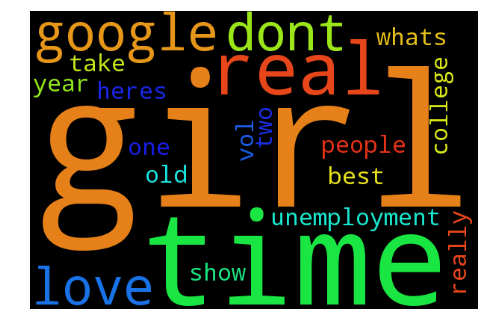

In [15]:
wc = WordCloud(width = 600, height = 400, margin = 5, max_words = 20, min_font_size = 12, random_state = None, max_font_size=None,  font_step=1, mode='RGBA')
wc.generate_from_text(' '.join(np.char.encode(popular_words(wordlist), encoding = 'utf-8')))
plt.imshow(wc)
plt.axis("off")
plt.show()

##Machine Learning


In [14]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split,ShuffleSplit
from sklearn.linear_model import RidgeCV,SGDRegressor
from sklearn.neighbors import KNeighborsRegressor

In [15]:
big_users.index = pd.to_datetime((big_users['first_visit_ts']*1e9).astype(int))
big_users['visit_year'], big_users['visit_month'], big_users['visit_weekday'], big_users['visit_hour'] = big_users.index.year,big_users.index.month,big_users.index.weekday,big_users.index.hour
ts_big_users = big_users[['visit_year','visit_month','visit_weekday','visit_hour','user_id_hash','relative_path','seconds_of_engaged_time']].reset_index()

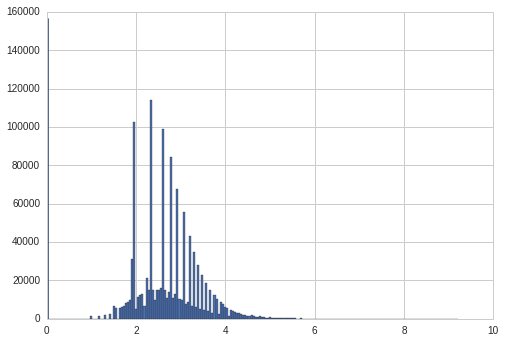

In [23]:
ts_big_users['seconds_of_engaged_time'].apply(lambda x:x**0.25).hist(bins=200)

In [47]:
ts_big_users['trans_engaged_time'] = ts_big_users['seconds_of_engaged_time']**0.25
ts_ml = ts_big_users[ts_big_users['trans_engaged_time']>0][['visit_month','visit_weekday','visit_hour','seconds_of_engaged_time','trans_engaged_time']].reset_index()

In [48]:
ts_ml.head()

,index,visit_month,visit_weekday,visit_hour,seconds_of_engaged_time,trans_engaged_time
0,1,2,0,19,285,4.108764
1,2,2,0,19,105,3.201086
2,3,2,0,19,165,3.584025
3,4,2,0,19,135,3.408658
4,5,2,0,19,60,2.783158


In [49]:
#X_users = ts_big_users[['visit_hour','visit_weekday']]
y_users = ts_ml['trans_engaged_time']
ts_ml[ 'sin_hour'] = np.sin(ts_ml['visit_hour']/24*np.pi*2)
ts_ml[ 'cos_hour'] = np.cos(ts_ml['visit_hour']/24*np.pi*2)
ts_ml[ 'sin_day'] = np.sin(ts_ml['visit_weekday']/7*np.pi*2)
ts_ml[ 'cos_day'] = np.cos(ts_ml['visit_weekday']/7*np.pi*2)
X_users = ts_ml[['sin_hour','cos_hour','sin_day','cos_day']]
shuffle_split_users = ShuffleSplit(len(y_users), test_size = 0.25, random_state = 42)
train_users_idx, test_users_idx = next(iter(shuffle_split_users))  #iterator

In [46]:
train_users_idx#.shape,test_users_idx.shape

array([131804, 814304, 753409, ..., 131932, 671155, 121958])

In [44]:
X_users.shape,y_users.shape

((1167697, 4), (1167697,))

In [50]:
X_users_train,X_users_test,y_users_train,y_users_test = X_users.loc[train_users_idx,:],X_users.loc[test_users_idx,:],y_users[train_users_idx],y_users[test_users_idx]

In [54]:
#y_users_train

In [49]:

rcv_users = RidgeCV(alphas = np.logspace(-1, 1, 5), cv = cross_validation.KFold(5))
rcv_users.fit(X_users_train, y_users_train)
score_rcv_users = rcv_users.score(X_users_test, y_users_test)

print score_rcv_users

0.000254160095739 -0.143177463855


In [56]:

knn_users = KNeighborsRegressor(n_neighbors = 50)
knn_users.fit(X_users_train, y_users_train)
y_pred = knn_users.predict(X_users_test)
score_knn_users = knn_users.score(X_users_test, y_users_test)


print score_knn_users

-0.0134355007228


In [ ]:
from sklearn import svm
clf = svm.SVR()
clf.fit(X_users_train, y_users_train) 
#SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
    #kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
y_pred = clf.predict(X_users_test)
score_svm = clf.score(X_users_test, y_users_test)

print score_svm

In [14]:
param = { 'n_neighbors': range(20, 81, 20) }
clf = grid_search.GridSearchCV( knn, param )
clf.fit(X_train, y_train)
clf.best_estimator_
clf.score(X_test,y_test)

-0.0095800195585580283

In [59]:

param = { 'alpha': [0.5,1] }
sgd = SGDRegressor()
clf = grid_search.GridSearchCV( sgd, param )
clf.fit(X_train, y_train)
clf.best_estimator_
#clf.score(X_test,y_test)

SGDRegressor(alpha=0.5, epsilon=0.1, eta0=0.01, fit_intercept=True,
       l1_ratio=0.15, learning_rate='invscaling', loss='squared_loss',
       n_iter=5, penalty='l2', power_t=0.25, random_state=None,
       shuffle=False, verbose=0, warm_start=False)

In [15]:
clf.score(X_test,y_test)

-0.0095800195585580283

In [ ]:
knn=neighbors.KNeighborsRegressor()

In [ ]:
nearest_neighbors_cv.best_estimator_
scores = cross_validation.cross_val_score(nearest_neighbors_cv, X_test, y_test, cv=5)

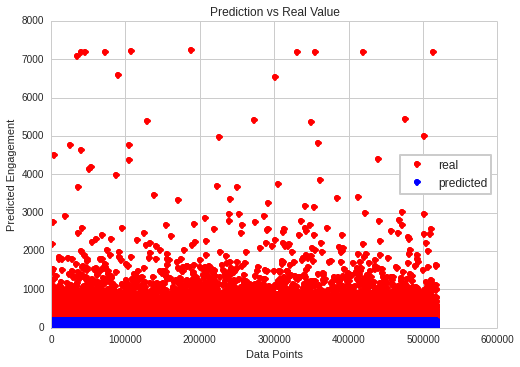

In [77]:
x=range(0,len(hour_test))

fig, ax = plt.subplots()

ax.scatter(X_test, y_test, c='k', label='data')
ax.plot(X_test, y_pred, c='g', label='prediction')
#ax.plot(x, eng_test,'o',label='real', color='red')
#ax.plot(x, eng_pred,'o',label='predicted', color='blue')
legend = ax.legend(loc='best', frameon=True, fontsize='large')
frame = legend.get_frame()
frame.set_facecolor('white')
#frame.set_edgecolor('red')
plt.xlabel('Data Points')
plt.ylabel('Predicted Engagement')
plt.title('Prediction vs Real Value')
frame.set_linewidth(2)
plt.show()

In [119]:

#star_pred = kneighborregressor.predict(longlat_test)


ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 1035916 while Y.shape[1] == 1035915

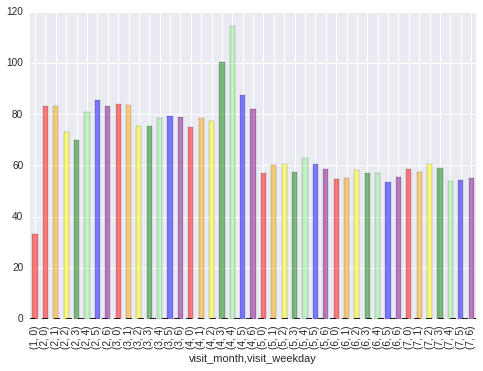

In [81]:
#colors=['r']+['r','orange','yellow','g','lightgreen','b','purple']*7
#m_w=ts.groupby(['visit_month','visit_weekday'])['seconds_of_engaged_time'].mean()
#m_w.plot(kind='bar', color=colors,alpha=0.5)
